# Experiments: Singapore sounding

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we perform the same tests using the Singapore sounding, which is much more moist.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as const
from metpy.units import concatenate
from pint import set_application_registry
set_application_registry(units)

from scipy.integrate import simps

import sys
from os import mkdir
from os.path import exists
import shelve

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, saturation_specific_humidity
from thermo import temperature_change
from entraining_parcel import EntrainingParcel

In [2]:
fig_path = (
    '/Users/tschanzer/OneDrive - UNSW/UNSW2021/T3/ToR/taste-of-research-21T3/'
    'notebooks/20211027_experiments_singapore/figures/')
if not exists(fig_path):
    mkdir(fig_path)

In [3]:
file = '../../soundings/48698 WSSS Singapore Observations at 00Z 02 Sep 2021.txt'
sounding = pd.read_fwf(
    file, names=['pressure', 'height', 'temperature', 'dewpoint'],
    usecols=[0, 1, 2, 3], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
height = sounding[:,1]*units.meter
temperature = sounding[:,2]*units.celsius
dewpoint = sounding[:,3]*units.celsius
singapore = Environment(
    pressure, height, temperature, dewpoint,
    info='48698 WSSS Singapore Observations at 00Z 02 Sep 2021',
    name='Singapore')

In [4]:
parcel = EntrainingParcel(singapore)

# Entrainment rate vs. dependent variables

We first fix the initial conditions and vary the entrainment rate. We use an environmental parcel from the Singapore sounding at $z=5.5$ km that has become saturated by precipitation.

## Height and velocity

In [39]:
singapore.height(520*units.mbar)

5539.317073170731 <Unit('meter')>

In [36]:
z_initial = 5.5*units.km
w_initial = 0*units.meter/units.second
p_initial = singapore.pressure(z_initial)
t_initial = singapore.wetbulb_temperature(z_initial)
q_initial = saturation_specific_humidity(p_initial, t_initial)
time = np.arange(0, 10.1, 0.1)*units.minute

rates = np.arange(0, 2.1, 0.5)/units.km

In [40]:
%%time
l_initial = 2e-3*units.dimensionless
sols = []
for i, rate in enumerate(rates):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, rates.size))
    sol = parcel.motion(
        time, z_initial, w_initial, t_initial, q_initial, l_initial, rate)
    sols.append(sol)
sys.stdout.write('\n')

Calculation 5 of 5
CPU times: user 1min 1s, sys: 259 ms, total: 1min 1s
Wall time: 1min 2s


In [51]:
with shelve.open('moist_motion_vs_entrainment_rate') as file:
    file['parcel'] = parcel
    file['z_initial'] = z_initial
    file['w_initial'] = w_initial
    file['t_initial'] = t_initial
    file['q_initial'] = q_initial
    file['l_initial'] = l_initial
    file['time'] = time
    file['rates'] = rates
    file['sols'] = sols
    print([x for x in file.keys()])

['w_initial', 'sols', 'z_initial', 'l_initial', 'time', 'rates', 'parcel', 'q_initial', 't_initial']


In [186]:
with shelve.open('moist_motion_vs_entrainment_rate') as file:
    sols = file['sols']

In [43]:
%%time
l_initial = 0*units.dimensionless
sols_dry = []
for i, rate in enumerate(rates):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, rates.size))
    sol = parcel.motion(
        time, z_initial, w_initial, t_initial, q_initial, l_initial, rate)
    sols_dry.append(sol)
sys.stdout.write('\n')

Calculation 5 of 5
CPU times: user 3.7 s, sys: 71 ms, total: 3.77 s
Wall time: 3.86 s


In [53]:
with shelve.open('dry_motion_vs_entrainment_rate') as file:
    file['parcel'] = parcel
    file['z_initial'] = z_initial
    file['w_initial'] = w_initial
    file['t_initial'] = t_initial
    file['q_initial'] = q_initial
    file['l_initial'] = l_initial
    file['time'] = time
    file['rates'] = rates
    file['sols'] = sols_dry
    print([x for x in file.keys()])

['w_initial', 'sols', 'z_initial', 't_initial', 'l_initial', 'time', 'rates', 'parcel', 'q_initial']


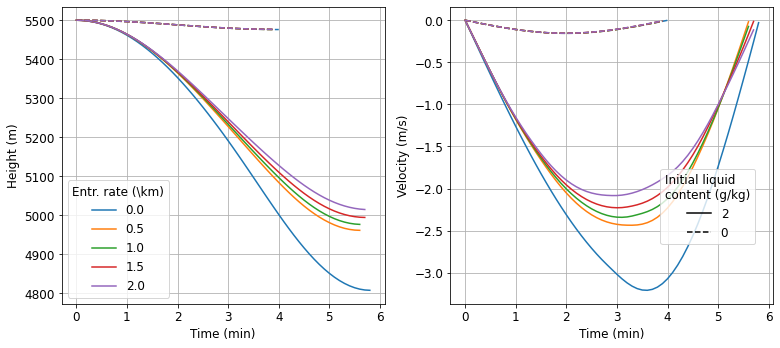

In [46]:
# simple height/velocity plot
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols):
    ax1.plot(time, sol.height, label=str(rates[i].m))
    ax2.plot(time, sol.velocity)
ax1.set_prop_cycle(None)
ax2.set_prop_cycle(None)
for i, sol in enumerate(sols_dry):
    ax1.plot(time, sol.height, '--')
    ax2.plot(time, sol.velocity, '--')
    
ax2.plot(0, 0, 'k-', label='2')
ax2.plot(0, 0, 'k--', label='0')

ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
lgd = ax1.legend(loc='lower left')
lgd.set_title('Entr. rate (\km)')
lgd = ax2.legend(loc=(0.65, 0.2))
lgd.set_title('Initial liquid\ncontent (g/kg)')
ax1.grid()
ax2.grid()

fig.tight_layout()
fig.savefig(
    fig_path + 'entrainment_rate_vs_motion.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: as for Sydney sounding. Additionally, the presence of liquid water may amplify the effect of entrainment rate, especially for very moist soundings where little water is able to initially evaporate into the parcel and most of the initial negative buoyancy is due to the weight of the water.

## Maximum/height-averaged velocity and mass flux

In [48]:
for sol in [*sols, *sols_dry]:
    z = sol.height[~np.isnan(sol.height)].m
    v = sol.velocity[~np.isnan(sol.velocity)].m
    massflux = sol.massflux[~np.isnan(sol.massflux)].m
    
    sol.velocity_zavg = 1/(z[-1] - z[0])*simps(v, z)*sol.velocity.units
    sol.massflux_zavg = 1/(z[-1] - z[0])*simps(massflux, z)*sol.massflux.units

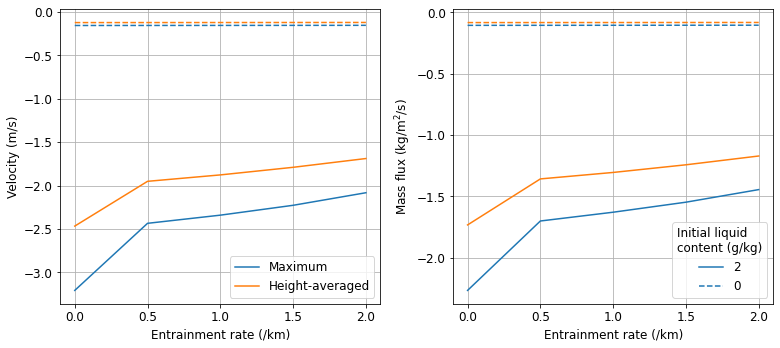

In [49]:
# maximum velocity and mass flux
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(rates, [np.nanmin(sol.velocity.m) for sol in sols], label='Maximum')
ax1.plot(rates, [sol.velocity_zavg.m for sol in sols], label='Height-averaged')
ax1.set_prop_cycle(None)
ax1.plot(rates, [np.nanmin(sol.velocity.m) for sol in sols_dry], '--')
ax1.plot(rates, [sol.velocity_zavg.m for sol in sols_dry], '--')
ax1.set(
    xlabel='Entrainment rate (/km)',
    ylabel='Velocity (m/s)')
ax1.grid()
ax1.legend()

ax2.plot(rates, [np.nanmin(sol.massflux.m) for sol in sols], label='2')
ax2.plot(rates, [sol.massflux_zavg.m for sol in sols])
ax2.set_prop_cycle(None)
ax2.plot(rates, [np.nanmin(sol.massflux.m) for sol in sols_dry], '--',
         label='0')
ax2.plot(rates, [sol.massflux_zavg.m for sol in sols_dry], '--')
ax2.set(
    xlabel='Entrainment rate (/km)',
    ylabel='Mass flux (kg/m$^2$/s)')
ax2.grid()
lgd = ax2.legend()
lgd.set_title('Initial liquid\ncontent (g/kg)')

fig.tight_layout()
fig.savefig(
    fig_path + 'entrainment_rate_vs_velocity.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: as for the Sydney sounding. Again, the presence of liquid water amplifies the effect of entrainment rate.

# Initial condition vs. dependent variables

We now fix the entrainment rate at 1/km and vary the amount of water initially added to the parcel by precipitation. We will consider the case where there is not enough precipitation to saturate the parcel, as well as the case where the parcel can become saturated and is given additional liquid water.

In [5]:
z_initial = 5.5*units.km
w_initial = 0*units.meter/units.second
p_initial = singapore.pressure(z_initial)

env_q = singapore.specific_humidity(z_initial)
max_dq = singapore.maximum_specific_humidity_change(z_initial)
wetbulb = singapore.wetbulb_temperature(z_initial)
q_initial = np.concatenate(
    (np.linspace(env_q, env_q + max_dq, 6)[1:-1],
     np.ones(6)*saturation_specific_humidity(p_initial, wetbulb)))
l_initial = np.concatenate((np.zeros(5), np.linspace(0, 2e-3, 6)[1:]))
t_initial = np.concatenate((
    singapore.temperature(z_initial) + temperature_change(q_initial[0:4] - env_q),
    np.ones(6)*wetbulb))

time = np.arange(0, 10.1, 0.1)*units.minute
rate = 1/units.km

In [6]:
%%time
sols = []
i = 0
for t, q, l in zip(t_initial, q_initial, l_initial):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, t_initial.size))
    sol = parcel.motion(time, z_initial, w_initial, t, q, l, rate)
    sols.append(sol)
    i += 1
sys.stdout.write('\n')

Calculation 10 of 10
CPU times: user 42.7 s, sys: 189 ms, total: 42.9 s
Wall time: 43.2 s


In [8]:
with shelve.open('motion_vs_initial_conditions') as file:
    file['parcel'] = parcel
    file['z_initial'] = z_initial
    file['w_initial'] = w_initial
    file['t_initial'] = t_initial
    file['q_initial'] = q_initial
    file['l_initial'] = l_initial
    file['time'] = time
    file['rate'] = rate
    file['sols'] = sols
    print([x for x in file.keys()])

['w_initial', 'sols', 'q_initial', 'z_initial', 'time', 'parcel', 'rate', 't_initial', 'l_initial']


In [193]:
with shelve.open('motion_vs_initial_conditions') as file:
    sols = file['sols']

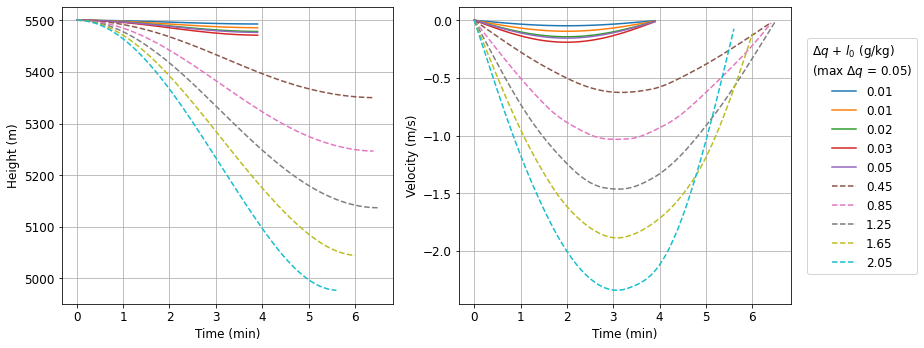

In [9]:
# simple height/velocity plot
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols[0:5]):
    ax1.plot(time, sol.height)
    ax2.plot(time, sol.velocity,
             label='{:.2f}'.format((q_initial[i] + l_initial[i] - env_q).m*1e3))
    
for i, sol in enumerate(sols[5:]):
    ax1.plot(time, sol.height, '--')
    ax2.plot(time, sol.velocity, '--',
             label='{:.2f}'.format((q_initial[i+5] + l_initial[i+5] - env_q).m*1e3))

ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
ax1.grid()
ax2.grid()
lgd = ax2.legend(loc=(1.05, 0.1))
lgd.set_title('$\Delta q$ + $l_0$ (g/kg)\n(max $\Delta q$ = {:.2f})'.format((q_initial[-1] - env_q).m*1e3))

fig.tight_layout()
fig.savefig(
    fig_path + 'initial_conditions_vs_motion.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: as for Sydney. The greater the amount of water initially added to the parcel, the further and the faster it descends. This is true for both initially subsaturated and saturated parcels.

In [10]:
for sol in sols:
    z = sol.height[~np.isnan(sol.height)].m
    v = sol.velocity[~np.isnan(sol.velocity)].m
    massflux = sol.massflux[~np.isnan(sol.massflux)].m
    
    sol.velocity_zavg = 1/(z[-1] - z[0])*simps(v, z)*sol.velocity.units
    sol.massflux_zavg = 1/(z[-1] - z[0])*simps(massflux, z)*sol.massflux.units

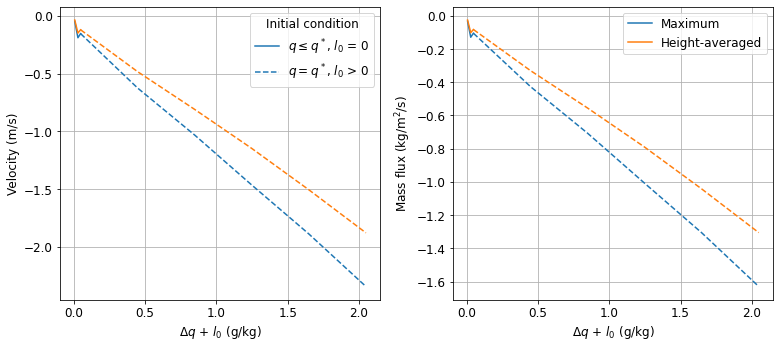

In [11]:
# maximum velocity and mass flux
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot((q_initial + l_initial - env_q)[0:5]*1e3,
         [np.nanmin(sol.velocity.m) for sol in sols[0:5]],
         label='$q \leq q^*$, $l_0$ = 0')
ax1.plot((q_initial + l_initial - env_q)[0:5]*1e3,
         [sol.velocity_zavg.m for sol in sols[0:5]])
ax2.plot((q_initial + l_initial - env_q)[0:5]*1e3,
         [np.nanmin(sol.massflux.m) for sol in sols[0:5]],
         label='Maximum')
ax2.plot((q_initial + l_initial - env_q)[0:5]*1e3,
         [sol.massflux_zavg.m for sol in sols[0:5]],
         label='Height-averaged')
ax1.set_prop_cycle(None)
ax2.set_prop_cycle(None)
ax1.plot((q_initial + l_initial - env_q)[4:]*1e3,
         [np.nanmin(sol.velocity.m) for sol in sols[4:]], '--',
         label='$q = q^*$, $l_0$ > 0')
ax1.plot((q_initial + l_initial - env_q)[4:]*1e3,
         [sol.velocity_zavg.m for sol in sols[4:]], '--')
ax2.plot((q_initial + l_initial - env_q)[4:]*1e3,
         [np.nanmin(sol.massflux.m) for sol in sols[4:]], '--')
ax2.plot((q_initial + l_initial - env_q)[4:]*1e3,
         [sol.massflux_zavg.m for sol in sols[4:]], '--')

ax1.set(
    xlabel='$\Delta q$ + $l_0$ (g/kg)',
    ylabel='Velocity (m/s)')
ax1.grid()
lgd = ax1.legend()
lgd.set_title('Initial condition')
ax2.set(
    xlabel='$\Delta q$ + $l_0$ (g/kg)',
    ylabel='Mass flux (kg/m$^2$/s)')
ax2.grid()
ax2.legend()

fig.tight_layout()
fig.savefig(
    fig_path + 'initial_conditions_vs_velocity.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: as for Sydney. Adding more water to a parcel initially produces a stronger downdraft. The relationship is almost linear.